In [21]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
#generate data 
max_degree=20
n_train,n_test=100,100
true_w=np.zeros((max_degree))
true_w[0:4]=np.array([5, 1.2, -3.4, 5.6])

features=np.random.normal(size=((n_train+n_test),1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
  poly_features[:,i]/=math.gamma(i+1)#gamma(n)=(n-1)!
#多维和一维向量点积
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape) 

type(labels)

true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]
labels.shape
poly_features.shape


torch.Size([200, 20])

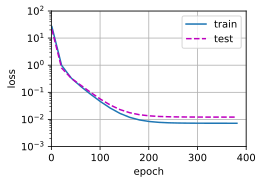

In [25]:
#计算数据集误差
def evaluate_loss(net,data_iter,loss):
  metric=d2l.Accumulator(2)
  for X,y in data_iter:
    l=loss(net(X),y)
    metric.add(l.sum(),l.numel())

  return metric[0]/metric[1]

#batch_size=18
#epoch_num=3
def train(train_features,test_features,train_labels,test_labels,num_epoch=400):
  loss=nn.MSELoss()
  net=nn.Sequential(nn.Linear(train_features.shape[-1],1,bias=None))
  #print(train_features.shape,train_features.shape[-1])
  trainer=torch.optim.SGD(net.parameters(),lr=0.01)
  batch_size=min(10,features.shape[0])
  #这里的shape一定要改
  train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
  test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size)
  animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[0,num_epoch],ylim=[1e-3,1e2],legend=['train','test'])
  
  for epoch in range(num_epoch):
    d2l.train_epoch_ch3(net,train_iter,loss,trainer)
    if epoch%20==0 :
      animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss))),
      #animator.add(epoch+1,(evaluate_loss(net,test_iter,loss)))
  return net[0].weight.data.numpy()  

w=train(poly_features[:n_train,:4],poly_features[n_test:,:4],labels[:n_train],labels[n_test:])

bug

1如果没有reshape，就不能进行tensor操作

2 polyfeature作为输入，否则无法降低loss（线性模型无法拟合高次模型）

In [29]:
train_iter=d2l.load_array((features[:100,:4],labels[:100].reshape(-1,1)),2)
for X,y in train_iter:
  print(X,y)
  break

train_iter=d2l.load_array((features[:100,:4],labels[:100]),4)
for X,y in train_iter:
  print(X,y)
  break

tensor([[-0.1643],
        [-0.8406]]) tensor([[4.7825],
        [2.1477]])
tensor([[ 0.0281],
        [-0.8982],
        [ 0.5600],
        [-1.0529]]) tensor([5.0247, 2.0985, 5.3457, 0.6457])


如果模型参数（模型复杂度）太少，就会欠拟合

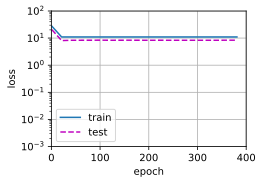

In [30]:
w=train(poly_features[:n_train,:2],poly_features[n_test:,:2],labels[:n_train],labels[n_test:])

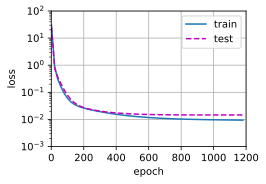

In [32]:
#如果模型参数（模型复杂度）太多，就会欠拟合
w=train(poly_features[:n_train,:20],poly_features[n_test:,:20],labels[:n_train],labels[n_test:],num_epoch=1200)